# Analysis of borrowing -- entropy method
## Based on word tables and using recurrent neural networks  

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Do this once in the kernel.
import sys
sys.path.append('/src/pybor')

# Set to automatically reload.
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import tensorflow as tf
from pybor.data import LexibankDataset
import pybor.entropies as entropies
import pybor.evaluate as evaluate
import pybor.neural as detector
import pybor.wold as wold

# Duplicate plot routines for notebook control   

In [3]:
from matplotlib import pyplot as plt

def plot_model_measures(
        measures=None,
        title=None,
        output_path=None,
        ):
    ## From Keras example
    print('measures', measures.keys())
    # Plot training & validation cross_entropy values
    plt.plot(measures['categorical_crossentropy'][1:])
    if 'val_categorical_crossentropy' in measures.keys():
        plt.plot(measures['val_categorical_crossentropy'][1:])
    if title:
        plt.title(title)
    plt.ylabel('Model Crossentropy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(measures['categorical_accuracy'][1:])
    if 'val_categorical_accuracy' in measures.keys():
        plt.plot(measures['val_categorical_accuracy'][1:])
    if title:
        plt.title(title)
    plt.ylabel('Model Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    if output_path is not None:
        plt.savefig(output_path, dpi=600)
        
    plt.close()



In [4]:
from matplotlib import pyplot as plt
import statistics
import math
import numpy as np

def plot_entropies(
    entropies1=None,
    entropies2=None,
    output_path=None,
    title='',
    label1='',
    label2='',
    graph_limit=None):
    

    cnt1 = f"{len(entropies1):6d}"
    avg1 = f"{statistics.mean(entropies1):6.3f}"
    std1 = f"{statistics.stdev(entropies1):6.3f}"
    cnt2 = f"{len(entropies2):6d}"
    avg2 = f"{statistics.mean(entropies2):6.3f}"
    std2 = f"{statistics.stdev(entropies2):6.3f}"

    # Drop most extreme values to determine graph limit.
    entropies = sorted(entropies1 + entropies2)
    upper_limit = graph_limit if graph_limit is not None else math.ceil(entropies[-4])
    lower_limit = math.floor(entropies[0])
    
    # Set frame horizontal for this measure.
    bins = np.linspace(lower_limit, upper_limit, 60)
    plt.figure(figsize=(8, 5))
    plt.hist(
        entropies1,
        bins,
        alpha=0.65,
        label=label1
        + r"$(n="
        + cnt1
        + ", \mu="
        + avg1
        + ", \sigma="
        + std1
        + ")$",
        color="blue",
    )
    plt.hist(
        entropies2,
        bins,
        alpha=0.65,
        label=label2
        + r"$(n="
        + cnt2
        + ", \mu="
        + avg2
        + ", \sigma="
        + std2
        + ")$",
        color="red",
    )
    plt.grid(axis="y", alpha=0.8)
    plt.legend(loc="upper right")

    plt.xlabel("Entropies")
    plt.ylabel("Frequency")
    plt.title(title)
    
    if output_path:
        plt.savefig(output_path, dpi=600)
        
    plt.show()
    plt.close()



# Plot entropy distributions corresponding to neural detection model.

In [5]:
def plot_entropy_distributions(neural=None):
    # Get corresponding data and models from pybor.
        
    # Plot training data from native and loan - native basis.
    native_train_tokens_ids = neural.native_data.get_data_tokens_ids(neural.native_data.training)
    loan_train_tokens_ids = neural.loan_data.get_data_tokens_ids(neural.loan_data.training)
    native_train_entropies_native = neural.native_model.calculate_entropies(native_train_tokens_ids)
    loan_train_entropies_native = neural.native_model.calculate_entropies(loan_train_tokens_ids)
    plot_entropies(native_train_entropies_native, loan_train_entropies_native, 
                   title="Inherited versus borrowed training entropies - Inherited basis", 
                   label1='Inherited training entropies', label2='Borrowed training entropies',
                   output_path = "./output/train-"+neural.native_model.model.name)

        
    #Plot testing data from native and loan - native basis.
    native_test_tokens_ids = neural.native_data.get_data_tokens_ids(neural.native_data.testing)
    loan_test_tokens_ids = neural.loan_data.get_data_tokens_ids(neural.loan_data.testing)
    native_test_entropies_native = neural.native_model.calculate_entropies(native_test_tokens_ids)
    loan_test_entropies_native = neural.native_model.calculate_entropies(loan_test_tokens_ids)
    plot_entropies(native_test_entropies_native, loan_test_entropies_native, 
                   title="Inherited versus borrowed testing entropies - Inherited basis", 
                   label1='Inherited testing entropies', label2='Borrowed testing entropies',
                   output_path = "./output/test-"+neural.native_model.model.name)


    if neural.loan_model is None: return  # Not dual model.
    
    native_train_entropies_loan = neural.loan_model.calculate_entropies(native_train_tokens_ids)
    loan_train_entropies_loan = neural.loan_model.calculate_entropies(loan_train_tokens_ids)

    native_test_entropies_loan = neural.loan_model.calculate_entropies(native_test_tokens_ids)
    loan_test_entropies_loan = neural.loan_model.calculate_entropies(loan_test_tokens_ids)

    plot_entropies(native_train_entropies_native, native_train_entropies_loan, 
                   title="Inherited training entropies - Inherited versus borrowed basis", 
                   label1='Inherited basis', label2='Borrowed basis',
                   output_path = "./output/train-native-"+neural.native_model.model.name+
                   neural.loan_model.model.name)

    
    plot_entropies(native_test_entropies_native, native_test_entropies_loan, 
                   title="Inherited testing entropies - Inherited versus borrowed basis", 
                   label1='Inherited basis', label2='Borrowed basis',
                   output_path = "./output/test-native-"+neural.native_model.model.name+
                   neural.loan_model.model.name)


    plot_entropies(loan_train_entropies_native, loan_train_entropies_loan, 
                   title="Borrowed training entropies - Inherited versus borrowed basis", 
                   label1='Inherited basis', label2='Borrowed basis',
                   output_path = "./output/train-loan-"+neural.native_model.model.name+
                   neural.loan_model.model.name)


    plot_entropies(loan_test_entropies_native, loan_test_entropies_loan, 
                   title="Borrowed testing entropies - Inherited versus borrowed basis", 
                   label1='Inherited basis', label2='Borrowed basis',
                   output_path = "./output/test-loan-"+neural.native_model.model.name+
                   neural.loan_model.model.name)

    # *** Entropy difference distributions.  Only this matters! ***
    
    loan_delta_train = [n - l for n, l in zip(loan_train_entropies_native,loan_train_entropies_loan)]
    native_delta_train = [n - l for n, l in zip(native_train_entropies_native,native_train_entropies_loan)]
    loan_delta_test = [n - l for n, l in zip(loan_test_entropies_native,loan_test_entropies_loan)]
    native_delta_test = [n - l for n, l in zip(native_test_entropies_native,native_test_entropies_loan)]

    plot_entropies(loan_delta_train, native_delta_train, 
                   title="Training entropy deltas - Inherited versus borrowed basis", 
                   label1='Borrowed word deltas', label2='Inherited word deltas',
                   output_path = "./output/train-delta-"+neural.native_model.model.name+
                   neural.loan_model.model.name)

    plot_entropies(loan_delta_test, native_delta_test, 
                   title="Testing entropy deltas - Inherited versus borrowed basis", 
                   label1='Borrowed word deltas', label2='Inherited word deltas',
                   output_path = "./output/test-delta-"+neural.native_model.model.name+
                   neural.loan_model.model.name)



# Custom version of examples/neural_example.py  

In [11]:
import pickle
from pathlib import Path

import attr

import pybor.config as config
import pybor.util as util

output_path = Path(config.BaseSettings().output_path).resolve()


def evaluate_prediction(model=None, data=None, title=''):
    print(f"Evaluate {title} dataset.")
    predictions = model.predict_data(data)
    train_metrics = evaluate.evaluate_model(predictions, data)


def evaluate_borrowing_detection_train_test(language=None, 
                                             train=None, 
                                             test=None, 
                                             detect_type=None,
                                             model_type=None,
                                             val_split=None,
                                             settings=None):

    print(f'*** Evaluation for {language}, detect type is {detect_type}, neural model type is {model_type}')

    if detect_type == 'native':
        neural = detector.NeuralNative(training=train,
                              testing=test,
                              language=language,
                              series='devel',
                              model_type=model_type,
                              val_split=val_split,
                              settings=settings)
        
        
    else:
        neural = detector.NeuralDual(training=train,
                            testing=test,
                            language=language,
                            series='devel',
                            model_type=model_type,
                            val_split=val_split,
                            settings=settings)

    neural.train()

    evaluate_prediction(neural, train, 'Training')
    evaluate_prediction(neural, test, 'Testing')   
    
    plot_model_measures(neural.native_history, 'native model')
    if detect_type == 'dual':    
        plot_model_measures(neural.loan_history, 'loan model')    
    
    plot_entropy_distributions(neural)

    
def perform_detection_by_language(languages=None, 
                                   form=None, 
                                   detect_type=None, 
                                   model_type=None, 
                                   test_split=None, 
                                   settings=None):
    
    wolddb = wold.get_wold_access()
    languages = wold.check_wold_languages(wolddb, languages)

    print(f'Languages {languages}.')
    for language in languages:
        table = wolddb.get_table(
                    language=language, form=form, classification='Borrowed'
                    )
        
        train, test = util.train_test_split(table, split=test_split)
        val_split = (test_split if test_split is None or test_split >= 1.0
                                else test_split/(1-test_split))
        
        evaluate_borrowing_detection_train_test(language=language, 
                                                 train=train, 
                                                 test=test,
                                                 detect_type=detect_type,
                                                 model_type=model_type, 
                                                 val_split=val_split,
                                                 settings=settings)


# Datasets selected from WOLD in format \[ident, [str], status]

loading data: 64289it [00:22, 2816.13it/s]


Languages ['English'].
*** Evaluation for English, detect type is dual, neural model type is recurrent
pybor.neural — INFO — Train length: 789, fit length: 649, val length: 140, test length: 142.
pybor.neural — INFO — Train length: 499, fit length: 410, val length: 89, test length: 86.
pybor.neural — INFO — training native model
pybor.entropies — INFO — Training neural <class 'pybor.entropies.NeuralWordRecurrent'> model.
pybor.entropies — INFO — Using per step learning rate decay 0.0026
pybor.entropies — INFO — Available quality measures: dict_keys(['loss', 'categorical_accuracy', 'categorical_crossentropy', 'val_loss', 'val_categorical_accuracy', 'val_categorical_crossentropy']).
pybor.entropies — INFO — Best epoch: 14 of 25.
pybor.entropies — INFO — Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=1.2524, accuracy=0.1729, cross_entropy=1.2234.
pybor.entropies — INFO — Validate dataset: loss=1.3760, accuracy=0.1502, cross_entropy=1.3509.
pybor.neural — INFO — t

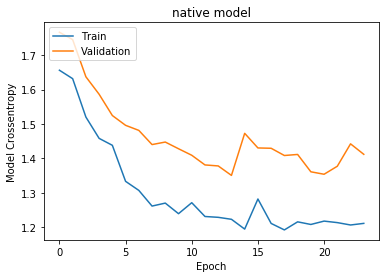

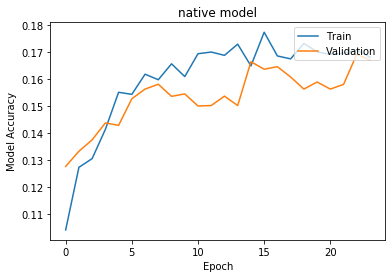

measures dict_keys(['loss', 'categorical_accuracy', 'categorical_crossentropy', 'val_loss', 'val_categorical_accuracy', 'val_categorical_crossentropy'])


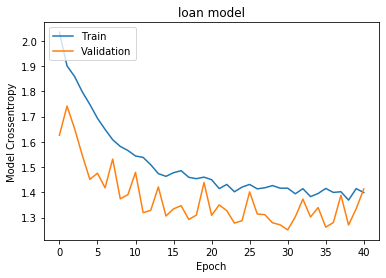

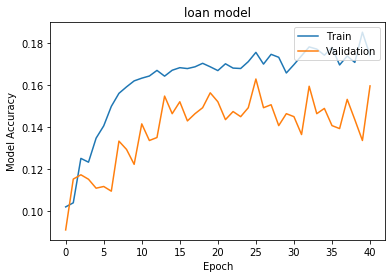

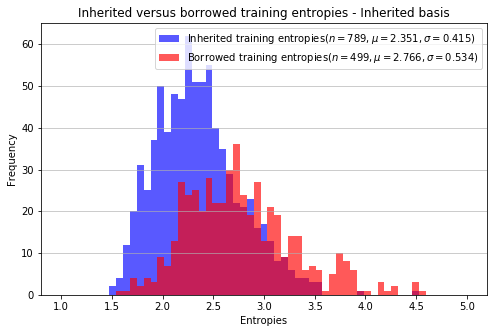

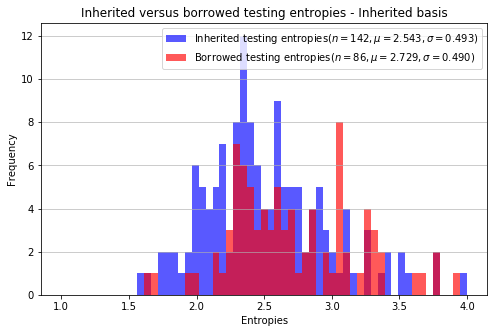

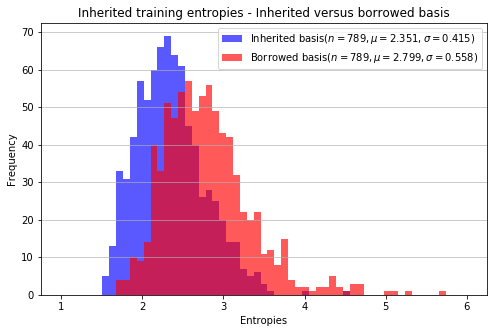

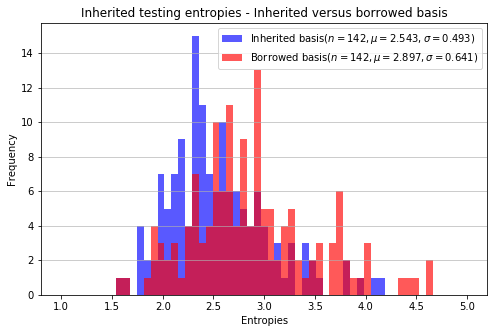

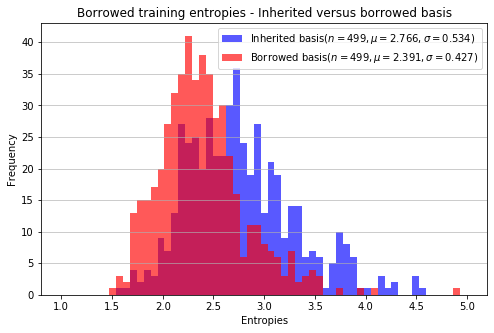

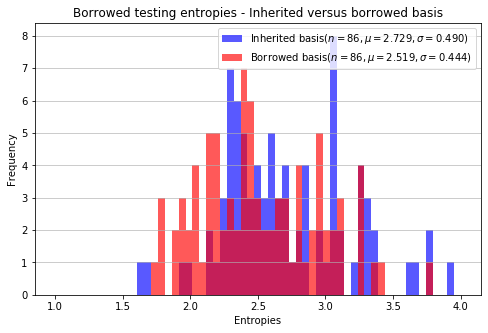

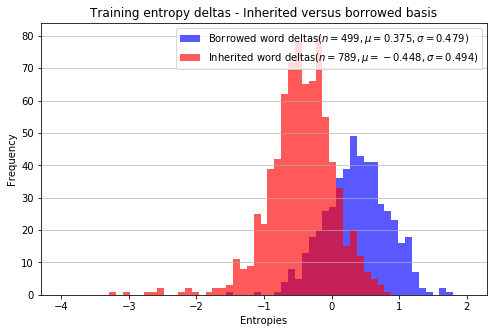

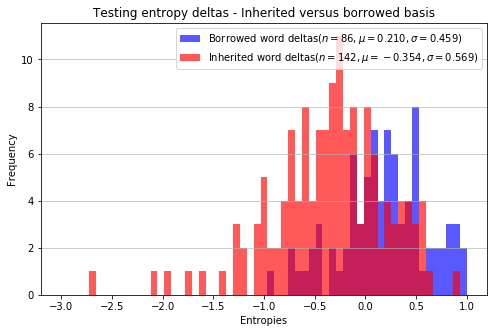

In [12]:
settings = config.RecurrentSettings(learning_rate = 0.00333)
perform_detection_by_language(languages='English', 
                               form='Tokens', 
                               detect_type='dual', 
                               model_type='recurrent', 
                               test_split=0.15,
                               settings=settings)

Languages ['Imbabura Quechua'].
*** Evaluation for Imbabura Quechua, detect type is dual, neural model type is recurrent
pybor.neural — INFO — Train length: 821, fit length: 676, val length: 145, test length: 129.
pybor.neural — INFO — Train length: 300, fit length: 247, val length: 53, test length: 69.
pybor.neural — INFO — training native model
pybor.entropies — INFO — Training neural <class 'pybor.entropies.NeuralWordRecurrent'> model.
pybor.entropies — INFO — Using per step learning rate decay 0.0025
pybor.entropies — INFO — Available quality measures: dict_keys(['loss', 'categorical_accuracy', 'categorical_crossentropy', 'val_loss', 'val_categorical_accuracy', 'val_categorical_crossentropy']).
pybor.entropies — INFO — Best epoch: 18 of 29.
pybor.entropies — INFO — Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=0.9809, accuracy=0.2040, cross_entropy=0.9599.
pybor.entropies — INFO — Validate dataset: loss=0.9696, accuracy=0.1764, cross_entropy=0.9159.
pybor

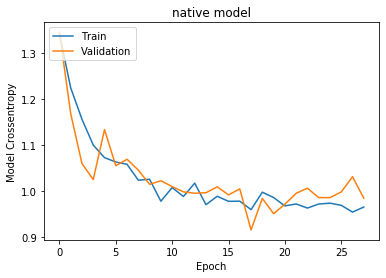

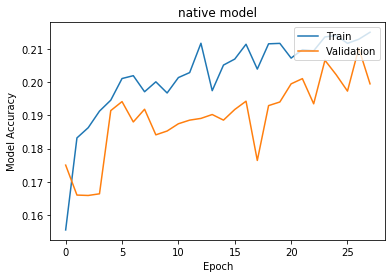

measures dict_keys(['loss', 'categorical_accuracy', 'categorical_crossentropy', 'val_loss', 'val_categorical_accuracy', 'val_categorical_crossentropy'])


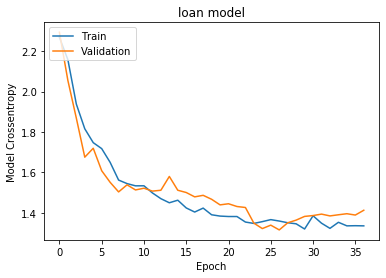

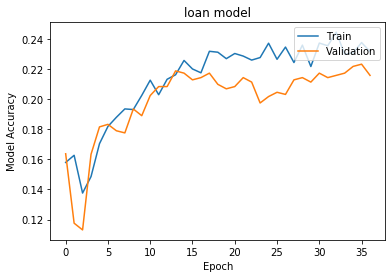

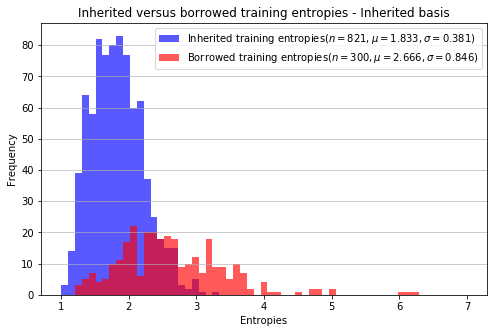

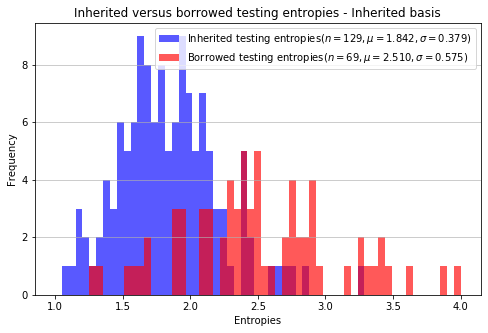

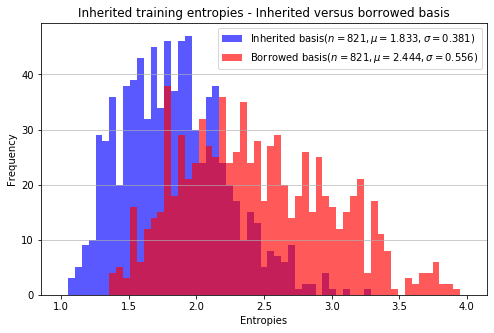

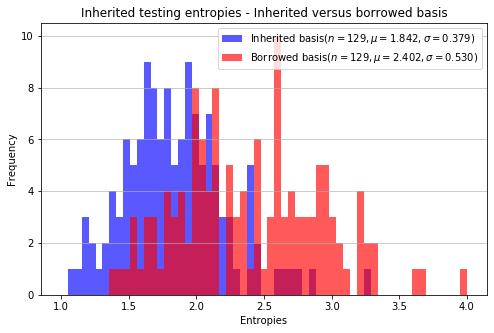

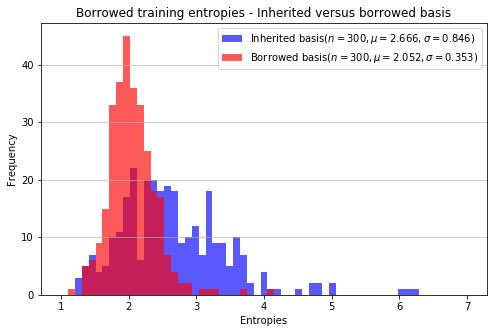

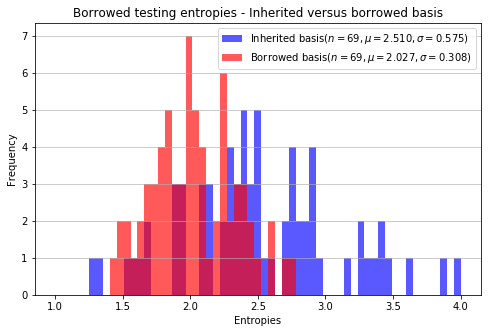

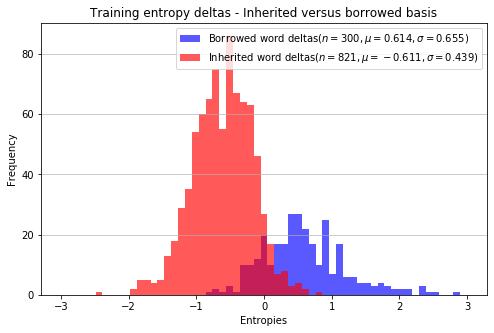

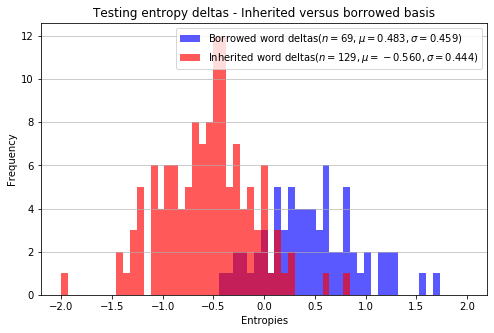

In [14]:
settings = config.RecurrentSettings(learning_rate = 0.00333)
perform_detection_by_language(languages='Imbabura Quechua', 
                               form='Tokens', 
                               detect_type='dual', 
                               model_type='recurrent', 
                               test_split=0.15,
                               settings=settings)

Languages ['Oroqen'].
*** Evaluation for Oroqen, detect type is dual, neural model type is recurrent
pybor.neural — INFO — Train length: 942, fit length: 775, val length: 167, test length: 169.
pybor.neural — INFO — Train length: 82, fit length: 67, val length: 15, test length: 12.
pybor.neural — INFO — training native model
pybor.entropies — INFO — Training neural <class 'pybor.entropies.NeuralWordRecurrent'> model.
pybor.entropies — INFO — Using per step learning rate decay 0.0022
pybor.entropies — INFO — Available quality measures: dict_keys(['loss', 'categorical_accuracy', 'categorical_crossentropy', 'val_loss', 'val_categorical_accuracy', 'val_categorical_crossentropy']).
pybor.entropies — INFO — Best epoch: 27 of 38.
pybor.entropies — INFO — Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=1.0963, accuracy=0.1456, cross_entropy=1.0415.
pybor.entropies — INFO — Validate dataset: loss=1.1630, accuracy=0.1542, cross_entropy=1.1381.
pybor.neural — INFO — train

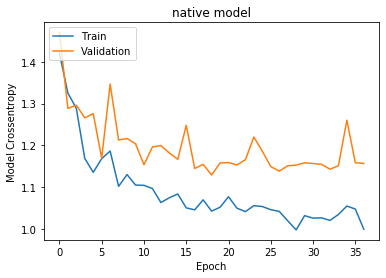

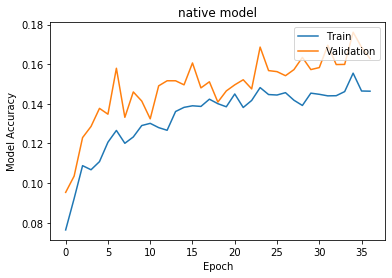

measures dict_keys(['loss', 'categorical_accuracy', 'categorical_crossentropy', 'val_loss', 'val_categorical_accuracy', 'val_categorical_crossentropy'])


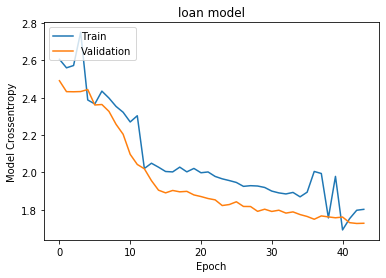

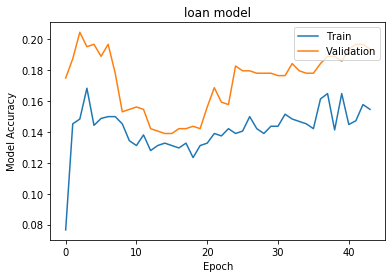

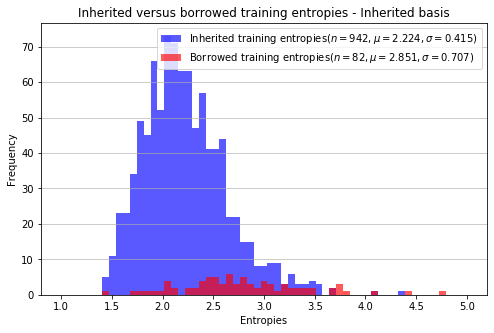

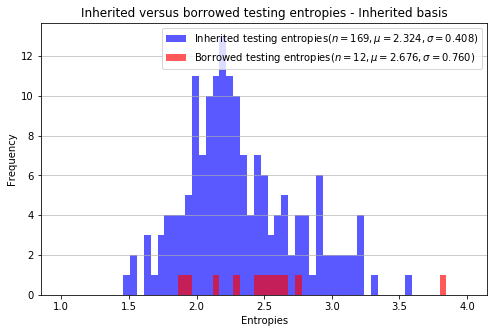

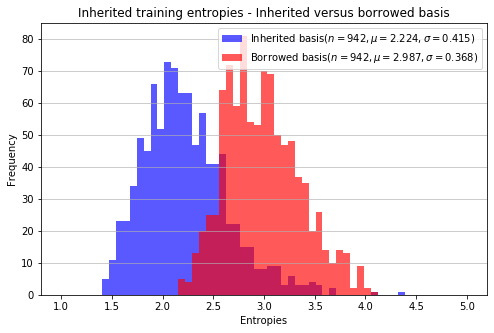

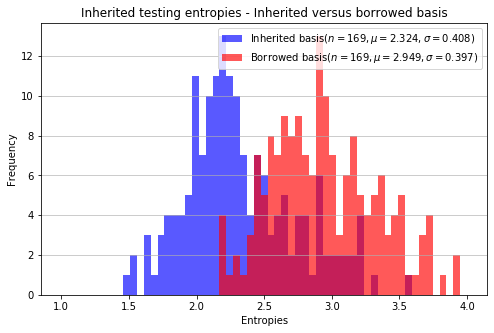

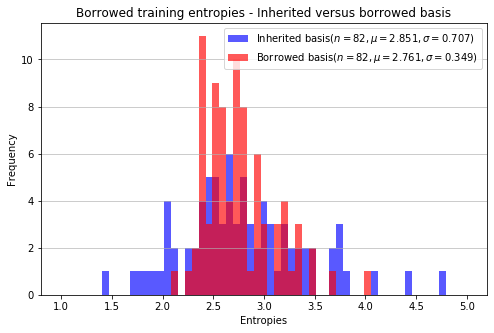

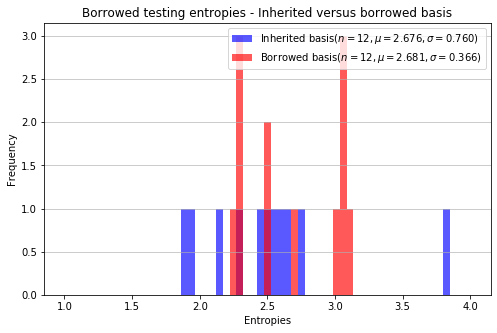

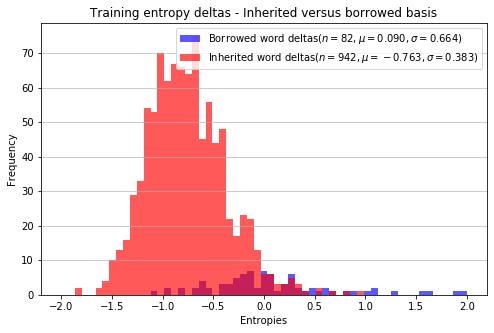

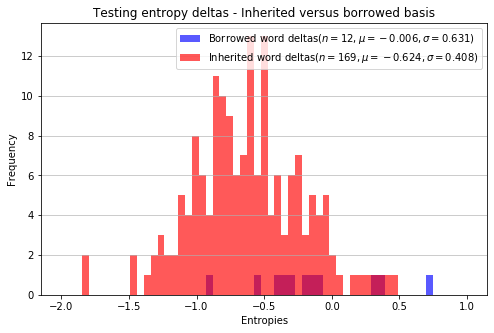

In [15]:
settings = config.RecurrentSettings(learning_rate = 0.00333)
perform_detection_by_language(languages='Oroqen', 
                               form='Tokens', 
                               detect_type='dual', 
                               model_type='recurrent', 
                               test_split=0.15,
                               settings=settings)